In [42]:
#hide
from fastbook import *
from fastai.vision.widgets import *

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x),  color)
    if title is not None: plt.title(title)

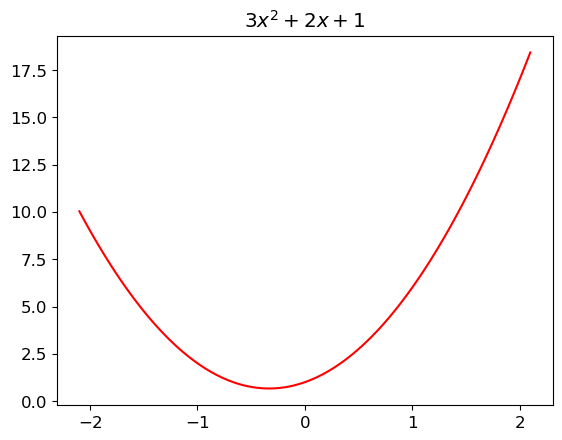

In [44]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

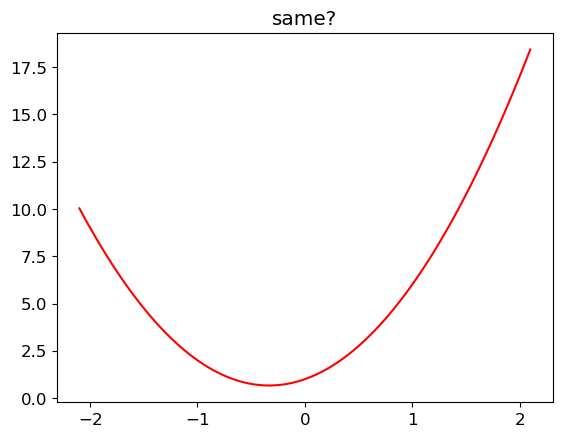

In [45]:
def quad(a, b, c, x): return a*x**2 + b*x + c
from functools import partial

def mk_quad(a, b, c): return partial(quad, a, b, c)
fxn = mk_quad(3, 2, 1)
fxn(1.5)

plot_function(f, "same?")

In [46]:
from numpy.random import normal, seed, uniform
np.random.seed(42)

def noise(x, scale): return normal(scale=scale, size = x.shape)
def add_noise(x, mult, add): return x * (1 + noise(x, mult) + noise(x, add))

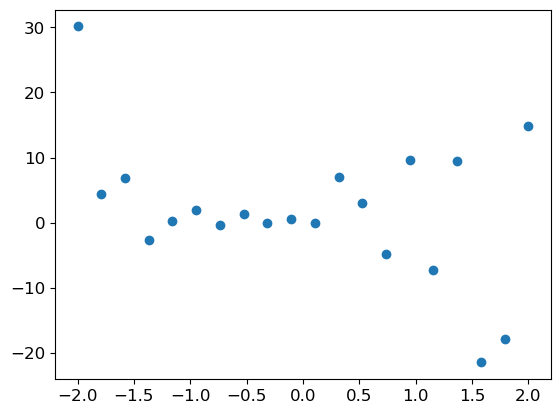

In [47]:
x = torch.linspace(-2, 2, steps=20)[:, None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x, y)

In [48]:
# Need a way to measure whet her our model is getting better

# mean squared error
def mse(preds, acts): return((preds - acts)**2).mean()

In [51]:
from ipywidgets import interact
from fastai.basics import *
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    plt.scatter(x, y)
    loss = mse(f(x), y)
#    plot_function(mk_quad(a, b, c), y_limit =(-3, 12))
    plot_function(f, ylim=(-3, 12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [52]:
def quad_mse(params):
    ''' Takes the parameters of a quadratic function and return the loss
    '''
    f = mk_quad(*params)
    return mse(f(x), y)

In [53]:
quad_mse([1.5, 1.5, 1.5])

TensorBase(129.2000)

In [66]:
# 1d tensor = rank 1 tensor
abc = torch.tensor([1.5, 1.5, 1.5])
# tell pytorch to calculate the gradient whenever we do a calculation for that tensor.
abc.requires_grad_()

loss = quad_mse(abc)
loss

loss.backward()
abc.grad

# no_grad() - means don't compute the derivative. This is not the loss - this is just us updating the gradients
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)
    print(f'loss: {loss:.2f}')

loss: 126.76


In [64]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}, loss={loss:.2f}')

step=0, loss=98.22
step=1, loss=94.47
step=2, loss=92.55
step=3, loss=92.53
step=4, loss=94.30


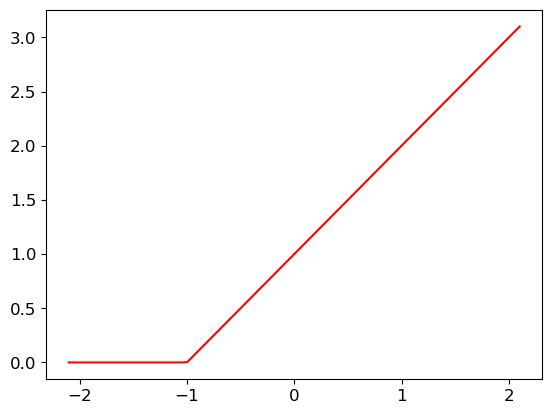

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [72]:
def rectified_linear(m, b, x):
    y = m*x + b
    # torch.clip takes anything that's greater than the number and makes it that number
    return torch.clip(y, 0.)

# plot_function(partial(rectified_linear, 1, 1))

@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1, 4))

In [75]:
def dbl_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_dbl_relu(m1, b1, m2, b2):
    plot_function(partial(dbl_relu, m1, b1, m2, b2), ylim=(-1, 6))
    
# This now gives us a function of two squigglies that we can change. This ordered relu gives us the ability to generate a polynomial fit.
# So we can generate a ReLU over any dimensions. We use gradient descent to find the adjust and fit the parameters to the data.

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

In [70]:
# this cell doesn't work

percgoal = 0.05
percdiff = 0.2
prev_loss = quad_mse(abc)
prev_loss.backward()
i = 0
while percdiff > percgoal:
    i += 1
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    percdiff = abs(prev_loss - loss) / loss
    print(f'step={i}, loss={loss:.2f} percdiff={percdiff}')

step=1, loss=122.25 percdiff=0.0


In [2]:
path = Path()
learn_inf = load_learner(path/'../bears.pkl')

In [3]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([6.0048e-06, 9.9997e-01, 1.9411e-05]))

In [8]:
learn_inf.dls.vocab
m = learn_inf.model
fxn = m.get_submodule('0.4.0.conv2')
list(fxn.parameters())

[Parameter containing:
 tensor([[[[ 2.5944e-02, -1.0457e-01, -4.7388e-03],
           [-8.6233e-02, -3.3021e-01, -1.0274e-01],
           [-5.7440e-02, -1.9076e-01, -5.4654e-02]],
 
          [[-1.6959e-02,  2.1378e-02, -2.1157e-03],
           [-3.3168e-03,  4.4999e-02, -1.1517e-02],
           [-5.9621e-02,  6.4826e-03,  2.9058e-03]],
 
          [[-4.4818e-03,  1.9634e-02,  1.3150e-02],
           [ 1.3055e-02, -7.7564e-03,  1.1910e-02],
           [ 1.3449e-02,  1.1097e-02,  5.4977e-03]],
 
          ...,
 
          [[ 1.2598e-03, -7.7693e-03,  2.0741e-02],
           [-4.0048e-02, -4.0407e-02, -3.4832e-02],
           [-2.0265e-02, -9.5385e-03,  1.3951e-02]],
 
          [[-2.3545e-03,  3.2292e-02, -4.3107e-03],
           [ 8.6021e-03,  1.0540e-02,  1.8072e-03],
           [-1.2781e-02, -1.0243e-02,  4.5711e-03]],
 
          [[ 1.5275e-02,  2.1332e-02, -7.1076e-03],
           [-1.4244e-02,  4.5971e-02,  2.1366e-02],
           [ 3.1305e-02,  6.6430e-02,  2.1470e-02]]],
 
 
   

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.